## Model testing

### data pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import joblib

import pickle
import os
import pdb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import pathlib
import glob
import datetime as dt

from numpy import newaxis
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, sgd, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import io

Using TensorFlow backend.


In [2]:
def repl_data_type(dataset):
    for col in dataset.columns:
        dataset[col] = dataset[col].astype(float)
    return dataset

def ordering(data):
    # ordering based on SendCount, Sfn, and Slot.
    data = data.sort_values(by=['aiSendCount', 'aiSfn', 'aiSlot'], ascending=True)
    data = repl_data_type(data)
    further_order_index = data[data['aiSfn']==0].index
    for _index in further_order_index:
        count = data.loc[_index, :]['aiSendCount']
        temp = data[data['aiSendCount']==count]
        #print(temp)
        sfn_range = temp['aiSfn'].unique()
        if 0 in sfn_range and 1023 in sfn_range:
            print(f"index {_index} need to be reordered!!")
            temp = temp.sort_values(by=['aiSfn','aiSlot'], ascending=[False, True])
            data[data['aiSendCount']==count] = temp.values
        #else:
        #    print(f"sfn_range = {sfn_range}")    
    
    # data = data.drop(171520)  # a very special row 
    return data

    # shifting sfn
def shift_sfn(df):  # input data are numpy
    data = df['aiSfn'].values
    superframe = 0
    firstframe = data[0]
    for i in range(data.shape[0]):
        if i > 0:
            if data[i - 1] - superframe * 1024 > data[i]:
                superframe += 1
            data[i] += superframe * 1024
    df['aiSfn'] = data - firstframe
    return df

def check_duplicate(df):
    df['delta_ct'] = df['aiSendCount']//2000
    dul_index = df.duplicated(subset=['aiSfn', 'aiSlot', 'delta_ct'])
    print(df[dul_index].index)
    #df = df[df.duplicated(subset=['aiSfn', 'aiSlot', 'delta_ct'])]
    df = df[~dul_index]
    df.drop(['delta_ct'], axis=1, inplace=True)
    print(f"Data shape after duplicate removal: {df.shape}")
    return df

def data_clean(filepath, droprows=None):
    # remove unvalid data, delete duplicate samples, sort the samples based on counter
    print("Data cleaning...")
    df = pd.read_csv(filepath, low_memory=False, error_bad_lines=False)
    if droprows is not None:
        df.drop(range(droprows), inplace=True)
        df = df.reset_index(drop=True)
    print(f"The shape of data: {df.shape}")
    df = df.drop(df[df['aiIsValid'] == 0].index)
    print(f"Number of valid samples: {df.shape}")
    df = ordering(df)

    df['time'] = df['aiTimeH'] + df['aiTimeL'] / 1000000
    tdx = df.index[0]
    df['time'] = df['time'] - df['time'][tdx]
    df = df.drop(['aiTimeH', 'aiTimeL'], axis=1)
    print(f"Total time duration for this dataset: {df['time'].max()}")

    t_start = time.time()
    df = check_duplicate(df)
    t_end = time.time()
    print(f"Time for remove duplicate: {t_end - t_start}.")

    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    df = shift_sfn(df)

    print(f"sfn_max = {df['aiSfn'].max()}, sfn min = {df['aiSfn'].min()}")

    sfn_range = df['aiSfn'].max() - df['aiSfn'].min() + 1
    missing_ratio = 1 - len(np.unique(df['aiSfn'].values)) / sfn_range
    print(f"The SFN missing ratio is {missing_ratio}")
    df = df.reset_index(drop=True)

    return df

def data_norm(data):
    # shifting bler, ack, and nack
    temp = data[['aiAck', 'aiNAck']] - data[['aiAck', 'aiNAck']].shift(1)
    temp = temp.fillna(0)
    data[['aiAck', 'aiNAck']] = temp.values
    #temp2 = data['aiBler'].values
    #temp2 = np.maximum(temp2, 0)
    #data['aiBler'] = temp2
    # insert a column to indicate how many slots within one sfn.
    nSlot = [1 if x > 0 else 0 for x in data['aiSlot']]
    data.insert(4, 'aiSlot_flag', nSlot)
    #data['aiSlot_flag'] = [1 if x>0 else 0 for x in data['aiSlot']]
    #columns = list(data.columns)
    #columns.insert(4, columns.pop(columns.index('aiSlot_flag')))
    #data = data[columns]
    # data normalization
    data['aiEth'] = data['aiEth'] * 8 / 1024 / 1024  # change unit from Bytes/s to MBits/s
    data['aiTbs'] = data['aiTbs'] * 8 / 1024 / 1024  # unit: Mbps
    data['aiRlcBuff'] = data['aiRlcBuff'] * 8 / 1024 / 1024  # unit: Mbps
    data['aiSendCount'] = data['aiSendCount'] - data['aiSendCount'][0]
    data['aiS1TeID'] = data['aiS1TeID'] - data['aiS1TeID'][0]
    data['aiBler'] = data['aiBler'] / 100
    data['aiSinr'] = data['aiSinr'] / 100
    data['aiRMCqi'] = data['aiRMCqi'] / 100
    id_cols = ['aiSendCount', 'aiIsValid', 'aiS1TeID', 'aiBearId']
    unique_cols = ['aiNumOfPrb', 'aiRssi', 'aiSinr', 'aiTa', 'aiPdcpBuffH', 'aiPdcpBuffL', 'aiCqiCmp', 'aiCqiDel', 'aiTm']
    #unique_cols = ['aiNumOfPrb', 'aiRssi', 'aiSinr', 'aiTa']
    print(f"Delete id cols: {id_cols}.")
    print(f"Delete unique value cols: {unique_cols}")
    #data = data.drop(id_cols, axis=1)
    #data = data.drop(unique_cols, axis=1)
    #data = data.reset_index(drop=True)
    print(f"The shape of dataset: {data.shape}")
    return data
    
def comb_sfn(data, idx, groupsize, pt=False):
    if pt:
        if idx%100==0:
            print(idx)
    return data.loc[idx, 'aiSfn'] // groupsize

def groupby_multp_sfn(data, groupsize):
    print(f"Groupy based on aiSfn with groupsize = {groupsize}...")

    agg_rule = {'time': np.min,
                'aiSfn': np.min,
                'aiSlot': 'sum',
                'aiSlot_flag': 'sum',
                'aiUeId': 'mean',
                'aiMcs': ['mean', np.min, np.max],
                'aiCqi':  'mean',
                'aiBler': 'mean',
                'aiAck': 'sum',
                'aiNAck': 'sum',
                'aiLoQueueTime': 'mean',
                'aiEth': 'sum',
                'aiRlcBuff': 'sum',
                'aiMod': 'mean',
                'aiRMCqi': 'mean',
                'aiTbs': 'sum'
                }
    tmp_dataset = data.groupby(lambda x: comb_sfn(data, x, groupsize)).agg(agg_rule)  # per sfn groupby

    tmp_dataset.columns = ['time', 'Sfn', 'Slot', 'nSlot', 'UeId',
                           'Mcs_mean', 'Mcs_min', 'Mcs_max',
                           'Cqi', 'Bler', 'Ack', 'Nack', 'LoQueueTime', 'Eth',
                           'RlcBuff', 'Modulation', 'RMCqi', 'Tbs']

    tmp_dataset = tmp_dataset.reset_index(drop=True)

    return tmp_dataset

def groupby_multp_sfn_simple(data, groupsize):
    print(f"Groupy based on aiSfn with groupsize = {groupsize}...")

    agg_rule = {'time': np.min,
                'aiSfn': np.min,
                'aiSlot': 'sum',
                'aiSlot_flag': 'sum',
                'aiUeId': 'mean',
                'aiMcs': ['mean', np.min, np.max],
                'aiCqi':  'mean',
                'aiBler': 'mean',
                'aiAck': 'sum',
                'aiNAck': 'sum',
                'aiLoQueueTime': 'mean',
                'aiEth': 'sum',
                'aiTbs': 'sum'
                }
    tmp_dataset = data.groupby(lambda x: comb_sfn(data, x, groupsize)).agg(agg_rule)  # per sfn groupby

    tmp_dataset.columns = ['time', 'Sfn', 'Slot', 'nSlot', 'UeId',
                           'Mcs_mean', 'Mcs_min', 'Mcs_max',
                           'Cqi', 'Bler', 'Ack', 'Nack', 'LoQueueTime', 'Eth', 'Tbs']

    tmp_dataset = tmp_dataset.reset_index(drop=True)

    return tmp_dataset

# def insert_missing_samples(data, groupsize):
#     #pdb.set_trace()
#     print(f"Insert missing rows.")
#     data['sample_id'] = data['Sfn']//groupsize
#     missing_number = data['sample_id'].max()+1-data.shape[0]
#     print(f"Total missing rows: {missing_number}")
#     if missing_number>0:
#         max_row = int(data['sample_id'].max() + 1)
#         existing = data['sample_id'].astype(int).values
#         missing_rows = list(set(list(range(max_row))) - set(existing))
#         print(missing_rows)
#         missing_rows.sort()
#         print(missing_rows)
#         for i in range(len(missing_rows)):
#             row_ind = missing_rows[i]
#             print(row_ind)
#             row = np.zeros(df.shape[1])
#             row[0] = row_ind*0.1
#             row[1] = row_ind*10
#             data.iloc[row_ind] = row
#     return data

def data_groupby(df, group_size):
    df = groupby_multp_sfn(df, group_size)
    df['Tbs_per_slot'] = df['Tbs']/df['nSlot'] * 100
    print(f"Number of samples: {df.shape} ")
    df['Sfn'] = df['Sfn']//group_size
    print(f"Number of missing samples: {df['Sfn'].max() + 1 - df.shape[0]}")
    gp = int(1024/group_size)
    df['Sfn'] = (df['Sfn']%gp)/100
    df['Slot'] = df['Slot']/100
    return df

def data_preprocessing(data_path, group_size, droprows=None):
    df = data_clean(data_path, droprows)
    df = data_norm(df)
    print(f"Start multiple sfn grouping, groupsize={group_size} ")
    df = groupby_multp_sfn(df, group_size)
    df['Tbs_per_slot'] = df['Tbs']/df['nSlot'] * 100
    print(f"Number of samples: {df.shape} ")
    df['Sfn'] = df['Sfn']//group_size
    print(f"Number of missing samples: {df['Sfn'].max() + 1 - df.shape[0]}")
    gp = int(1024/group_size)
    df['Sfn'] = (df['Sfn']%gp)/100
    df['Slot'] = df['Slot']/100
    #df = insert_missing_samples(df, group_size)
    return df

In [4]:
filepath = './dataset/20190904_QoE/bad_qoe_Result_20190904-162553.csv'
df = data_clean(filepath=filepath)
df = data_norm(df)
df.head()

Data cleaning...
The shape of data: (369424, 30)
Number of valid samples: (359193, 30)
index 5499 need to be reordered!!
index 11762 need to be reordered!!
index 11763 need to be reordered!!
index 30294 need to be reordered!!
index 36321 need to be reordered!!
Total time duration for this dataset: 612.4739608764648
Int64Index([  1904,  94666,  98889, 144689, 191436, 191437, 191438, 234435,
            234436, 234437, 234438],
           dtype='int64')


/home/jianwzha/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Data shape after duplicate removal: (359182, 29)
Time for remove duplicate: 0.31731176376342773.
sfn_max = 61247.0, sfn min = 0.0
The SFN missing ratio is 0.04530760188087779
Delete id cols: ['aiSendCount', 'aiIsValid', 'aiS1TeID', 'aiBearId'].
Delete unique value cols: ['aiNumOfPrb', 'aiRssi', 'aiSinr', 'aiTa', 'aiPdcpBuffH', 'aiPdcpBuffL', 'aiCqiCmp', 'aiCqiDel', 'aiTm']
The shape of dataset: (359182, 29)


,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,...,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
0,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,19.0,273.0,...,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000
1,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,20.0,273.0,...,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000
2,0.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,...,0.117081,0.0,0.0,0.071617,2.0,9.02,4.294967e+09,0.0,1.0,0.000000
3,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,...,0.118057,0.0,0.0,0.118752,4.0,9.08,4.294967e+09,0.0,1.0,0.005009
4,1.0,1.0,0.0,18.0,1,0.0,0.0,0.0,5.0,273.0,...,0.118057,0.0,0.0,0.118752,2.0,9.08,4.294967e+09,0.0,1.0,0.005009


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.describe()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
count,359182.000000,359182.0,359182.00000,359182.000000,359182.0,359182.0,359182.0,359182.0,359182.000000,359182.0,359182.000000,359182.000000,359182.000000,359182.0,359182.000000,359182.000000,359182.000000,359182.000000,359182.000000,359182.000000,359182.0,359182.0,359182.000000,359182.000000,359182.000000,3.591820e+05,359182.0,359182.0,359182.000000
mean,60929.374988,1.0,30568.94667,9.413679,1.0,0.0,0.0,0.0,13.538888,273.0,0.070936,11.683910,14.821561,0.0,14.753106,0.861148,0.139152,0.009995,0.255987,0.119214,0.0,0.0,0.059431,4.459555,8.952570,4.294967e+09,0.0,1.0,305.689227
std,35318.063713,0.0,17719.49654,5.094206,0.0,0.0,0.0,0.0,7.288516,0.0,0.039460,0.464949,8.520291,0.0,0.892703,1.140074,0.415952,0.550258,0.500856,0.011070,0.0,0.0,0.075086,1.725804,0.246055,0.000000e+00,0.0,0.0,177.194980
min,0.000000,1.0,0.00000,2.000000,1.0,0.0,0.0,0.0,0.000000,273.0,0.005135,11.000000,0.000000,0.0,13.440000,0.000000,0.000000,0.000000,0.000000,0.057709,0.0,0.0,0.000000,2.000000,8.000000,4.294967e+09,0.0,1.0,0.000000
25%,30328.250000,1.0,15216.00000,5.000000,1.0,0.0,0.0,0.0,7.000000,273.0,0.033203,11.000000,8.300000,0.0,13.440000,0.000000,0.000000,0.000000,0.000000,0.112732,0.0,0.0,0.000000,2.000000,8.950000,4.294967e+09,0.0,1.0,152.158893
50%,60909.000000,1.0,30559.00000,10.000000,1.0,0.0,0.0,0.0,18.000000,273.0,0.072281,12.000000,14.100000,0.0,15.360000,0.000000,0.000000,0.000000,0.000000,0.120186,0.0,0.0,0.011269,6.000000,9.020000,4.294967e+09,0.0,1.0,305.587512
75%,91674.750000,1.0,45994.00000,15.000000,1.0,0.0,0.0,0.0,19.000000,273.0,0.113388,12.000000,20.070000,0.0,15.360000,2.000000,0.000000,0.000000,0.000000,0.126831,0.0,0.0,0.118752,6.000000,9.070000,4.294967e+09,0.0,1.0,459.942397
max,122077.000000,1.0,61247.00000,18.000000,1.0,0.0,0.0,0.0,22.000000,273.0,0.144585,12.000000,100.000000,0.0,15.360000,6.000000,5.000000,35.000000,7.000000,0.164803,0.0,0.0,0.638741,6.000000,10.260000,4.294967e+09,0.0,1.0,612.473961


In [18]:
dul_index2 = df.duplicated(subset=['aiLoQueueTime', 'aiEth'])
df_LoEth = df[~dul_index2]
df_LoEth.shape

(17096, 30)

## Features

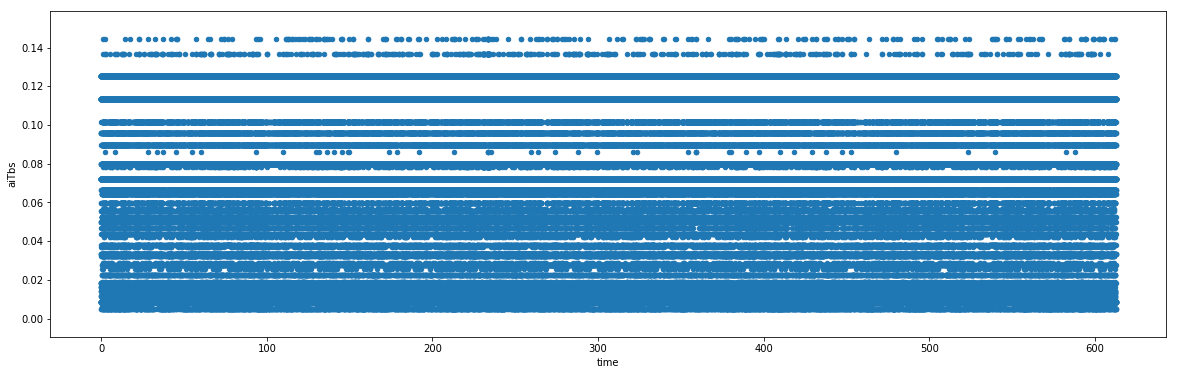

In [7]:
df.plot.scatter(x='time', y='aiTbs', figsize=(20,6))

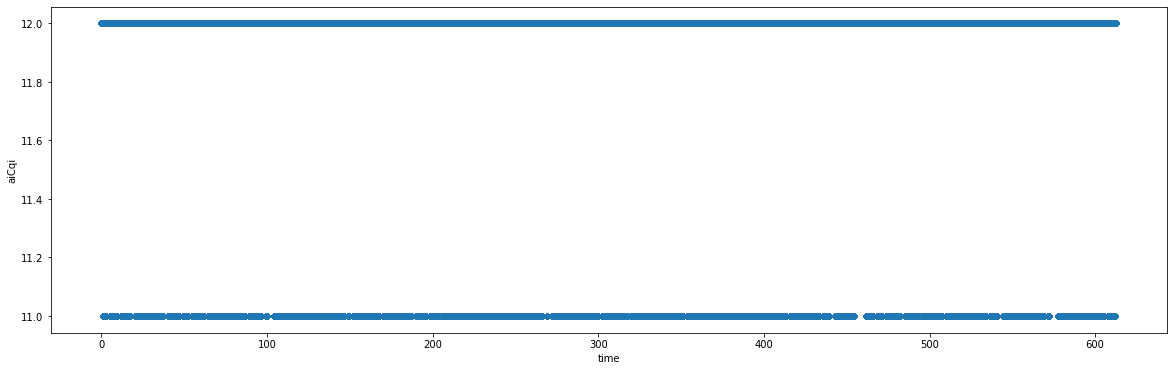

In [9]:
df.plot.scatter(x='time', y='aiCqi', figsize=(20,6))

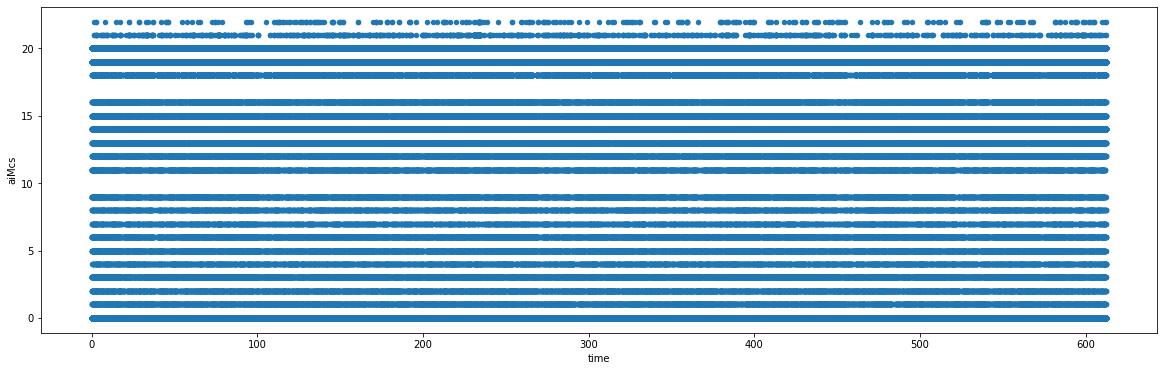

In [10]:
df.plot.scatter(x='time', y='aiMcs', figsize=(20,6))

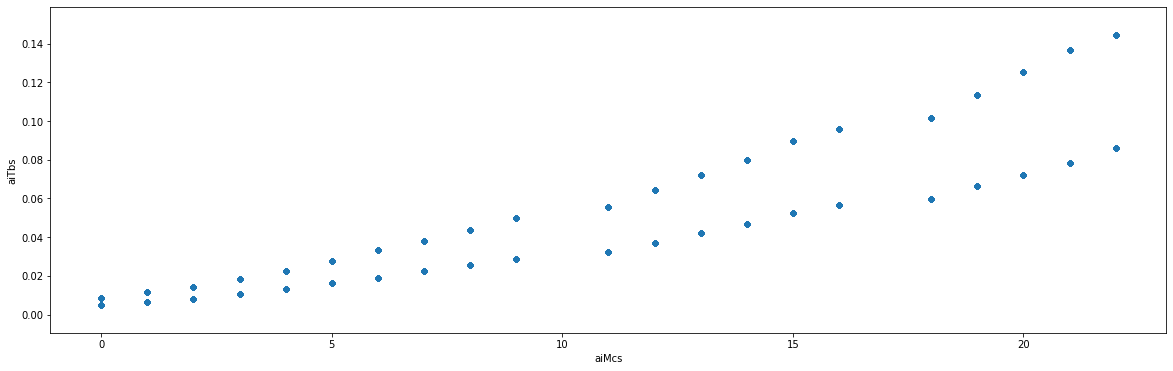

In [11]:
df.plot.scatter(x='aiMcs', y='aiTbs', figsize=(20,6))

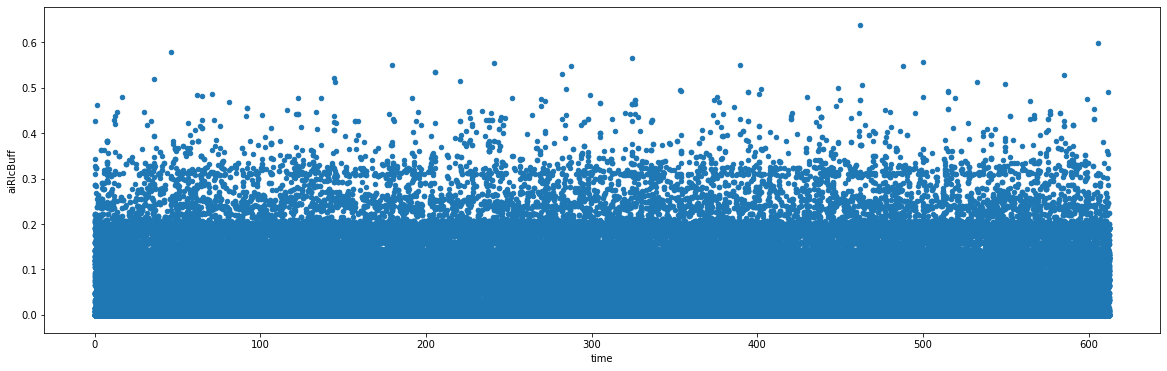

In [12]:
df.plot.scatter(x='time',y='aiRlcBuff', figsize=(20,6))

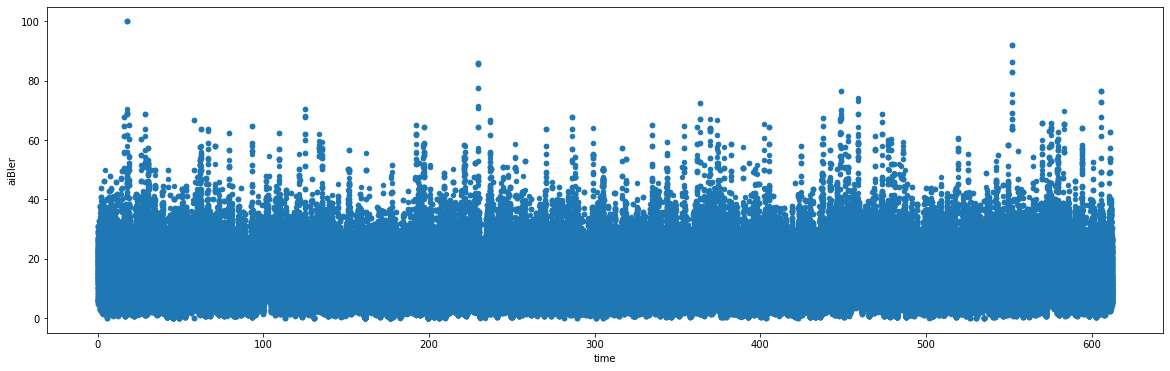

In [13]:
df.plot.scatter(x='time',y='aiBler', figsize=(20,6))

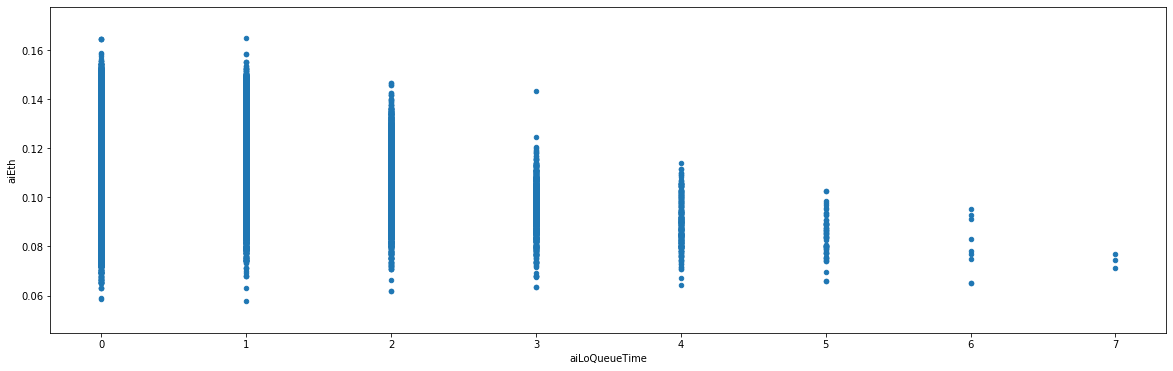

In [14]:
df.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

In [32]:

def plot_relation(df, var1, var2, ylim=80000):
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1, y=var2, ylim=(0, ylim))
    
def plot_box(varx, vary, data, ylim):
    data = pd.concat([data[vary], data[varx]], axis=1)
    f, ax = plt.subplots(figsize=(12,10))
    fig = sns.boxplot(x=varx, y=vary, data=data)
    fig.axis(ymin=0, ymax=ylim)
    
def correlation_heatmap(corr):

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(corr, vmax=1.0, center=0, cmap="YlGnBu", fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .80})
    #savepath = os.path.join('.', str(figID))
    #plt.savefig(savepath)
    plt.show();

In [16]:
mcs_range = np.unique(df['aiMcs'])
for _mcs in mcs_range:
    _tbs = np.unique(df[df['aiMcs']==_mcs]['aiTbs'])
    _tbs = _tbs*1024*1024/8
    print(f"mcs = {_mcs}, tbs = {_tbs}")


mcs = 0.0, tbs = [ 673. 1152.]
mcs = 1.0, tbs = [ 881. 1505.]
mcs = 2.0, tbs = [1089. 1857.]
mcs = 3.0, tbs = [1410. 2433.]
mcs = 4.0, tbs = [1729. 2946.]
mcs = 5.0, tbs = [2112. 3649.]
mcs = 6.0, tbs = [2496. 4352.]
mcs = 7.0, tbs = [2946. 4992.]
mcs = 8.0, tbs = [3393. 5763.]
mcs = 9.0, tbs = [3777. 6528.]
mcs = 11.0, tbs = [4227. 7298.]
mcs = 12.0, tbs = [4867. 8448.]
mcs = 13.0, tbs = [5505. 9474.]
mcs = 14.0, tbs = [ 6147. 10497.]
mcs = 15.0, tbs = [ 6913. 11781.]
mcs = 16.0, tbs = [ 7429. 12549.]
mcs = 18.0, tbs = [ 7813. 13322.]
mcs = 19.0, tbs = [ 8709. 14862.]
mcs = 20.0, tbs = [ 9474. 16397.]
mcs = 21.0, tbs = [10247. 17925.]
mcs = 22.0, tbs = [11272. 18951.]


In [17]:
std_zero_lst= []
valid_lst = []
for _col in df.columns:
    if df[_col].std() == 0:
        std_zero_lst.append(_col)
    else:
        valid_lst.append(_col)
print(f"zero std features: {std_zero_lst}")
print(f"valid features: {valid_lst}")

zero std features: ['aiIsValid', 'aiSlot_flag', 'aiS1TeID', 'aiUeId', 'aiBearId', 'aiNumOfPrb', 'aiRssi', 'aiPdcpBuffH', 'aiPdcpBuffL', 'aiCqiCmp', 'aiCqiDel', 'aiTm']
valid features: ['aiSendCount', 'aiSfn', 'aiSlot', 'aiMcs', 'aiTbs', 'aiCqi', 'aiBler', 'aiSinr', 'aiAck', 'aiNAck', 'aiTa', 'aiLoQueueTime', 'aiEth', 'aiRlcBuff', 'aiMod', 'aiRMCqi', 'time']


## Grouping

In [8]:
filepath = './dataset/raw_data/20190904_QoE/bad_qoe_Result_20190904-162553.csv'
time_period = 8# 10sfn = 100ms
dfg = data_groupby(df, time_period)
dfg.head()

Groupy based on aiSfn with groupsize = 8...
Number of samples: (7656, 19) 
Number of missing samples: 0.0


,time,Sfn,Slot,nSlot,UeId,Mcs_mean,Mcs_min,Mcs_max,Cqi,Bler,Ack,Nack,LoQueueTime,Eth,RlcBuff,Modulation,RMCqi,Tbs,Tbs_per_slot
0,0.000000,0.00,5.05,57,0.0,12.701754,0.0,20.0,12.0,10.728947,47.0,7.0,0.122807,6.659286,2.328560,4.210526,9.032982,3.770691,6.615247
1,0.075243,0.01,4.24,46,0.0,13.304348,0.0,20.0,12.0,15.336957,38.0,10.0,0.369565,5.320129,3.269920,4.478261,9.041304,3.260803,7.088703
2,0.170560,0.02,3.36,30,0.0,13.066667,0.0,20.0,12.0,13.230333,23.0,6.0,0.333333,3.866348,2.043877,4.333333,9.056000,2.083725,6.945750
3,0.235769,0.03,5.74,54,0.0,14.092593,0.0,20.0,12.0,19.462593,44.0,9.0,0.425926,6.132637,3.911934,4.555556,9.033889,3.897163,7.216969
4,0.316050,0.04,4.90,51,0.0,13.450980,0.0,20.0,12.0,24.266275,41.0,11.0,0.294118,5.882545,3.270279,4.352941,9.030980,3.562759,6.985803


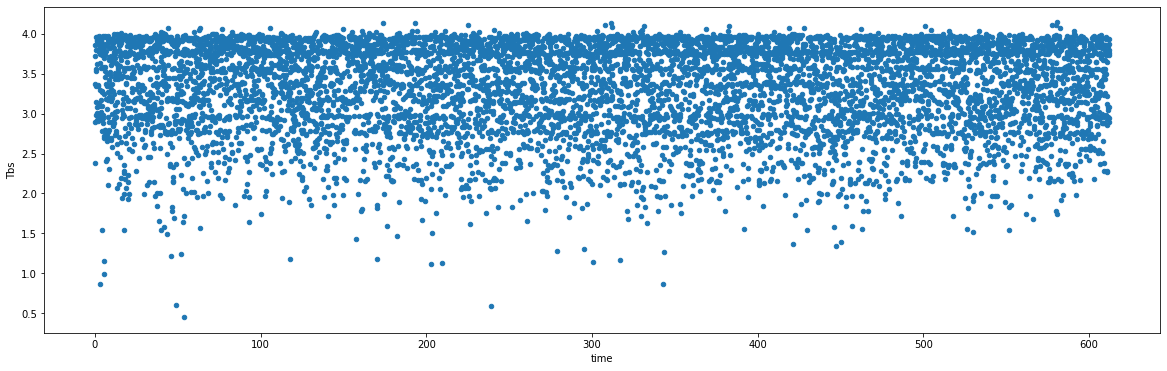

In [20]:
dfg.plot.scatter(x='time', y='Tbs', figsize=(20,6))

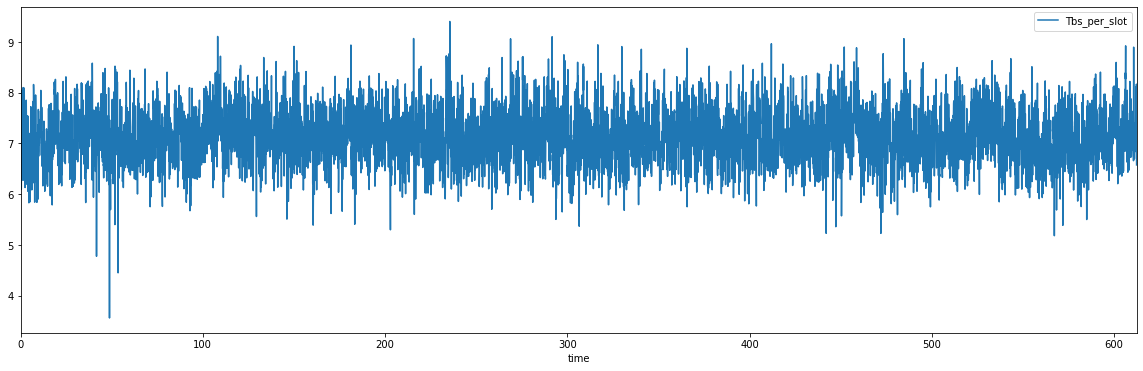

In [21]:
dfg.plot(x='time', y='Tbs_per_slot', figsize=(20,6))

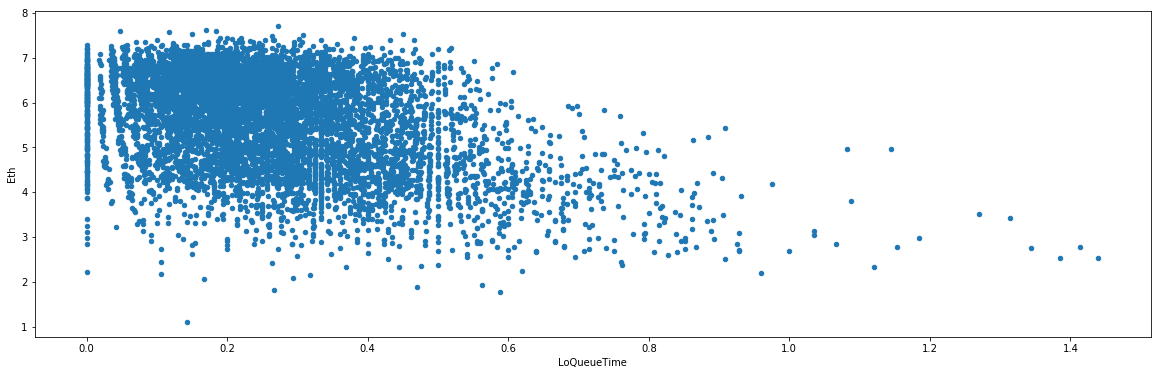

In [9]:
dfg.plot.scatter(x='LoQueueTime',y='Eth', figsize=(20,6))

In [10]:
dfg['label']= 2
dfg.head()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
0,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,19.0,273.0,0.113388,12.0,5.87,0.0,15.36,0.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
1,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,20.0,273.0,0.072281,12.0,5.80,0.0,15.36,1.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
2,0.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,0.008789,12.0,5.80,0.0,15.36,0.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,2.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
3,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,0.072281,12.0,5.44,0.0,15.36,2.0,0.0,0.0,1.0,0.118057,0.0,0.0,0.118752,4.0,9.08,4.294967e+09,0.0,1.0,0.005009,2
4,1.0,1.0,0.0,18.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,5.30,0.0,15.36,1.0,0.0,0.0,1.0,0.118057,0.0,0.0,0.118752,2.0,9.08,4.294967e+09,0.0,1.0,0.005009,2


In [7]:
df['label']=2
df.head()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
0,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,19.0,273.0,0.113388,12.0,5.87,0.0,15.36,0.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
1,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,20.0,273.0,0.072281,12.0,5.80,0.0,15.36,1.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,6.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
2,0.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,0.008789,12.0,5.80,0.0,15.36,0.0,0.0,0.0,0.0,0.117081,0.0,0.0,0.071617,2.0,9.02,4.294967e+09,0.0,1.0,0.000000,2
3,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,0.072281,12.0,5.44,0.0,15.36,2.0,0.0,0.0,1.0,0.118057,0.0,0.0,0.118752,4.0,9.08,4.294967e+09,0.0,1.0,0.005009,2
4,1.0,1.0,0.0,18.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,5.30,0.0,15.36,1.0,0.0,0.0,1.0,0.118057,0.0,0.0,0.118752,2.0,9.08,4.294967e+09,0.0,1.0,0.005009,2


# normal data

In [8]:
filepath = './dataset/20190904_QoE/normal_qoe_Result_20190904-171108.csv'
df_normal = data_clean(filepath=filepath)
df_normal = data_norm(df_normal)
df_normal.head()

Data cleaning...
The shape of data: (359833, 30)
Number of valid samples: (351610, 30)
index 7699 need to be reordered!!
index 7700 need to be reordered!!
index 13670 need to be reordered!!
index 13671 need to be reordered!!
index 19709 need to be reordered!!
index 19710 need to be reordered!!
index 25736 need to be reordered!!
index 25737 need to be reordered!!
index 37818 need to be reordered!!
index 43682 need to be reordered!!
index 102824 need to be reordered!!
index 114672 need to be reordered!!
index 114673 need to be reordered!!
index 132828 need to be reordered!!
index 156625 need to be reordered!!
index 162545 need to be reordered!!
index 168701 need to be reordered!!
index 168702 need to be reordered!!
index 174720 need to be reordered!!
index 251468 need to be reordered!!
index 269526 need to be reordered!!
index 292904 need to be reordered!!
index 299017 need to be reordered!!
index 299018 need to be reordered!!
index 305003 need to be reordered!!
index 311137 need to be r

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
0,0.0,1.0,0.0,16.0,1,0.0,0.0,0.0,21.0,273.0,0.136757,12.0,8.42,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,6.0,9.52,4.294967e+09,0.0,1.0,0.0
1,0.0,1.0,0.0,17.0,1,0.0,0.0,0.0,2.0,273.0,0.014168,12.0,8.21,0.0,15.36,1.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.52,4.294967e+09,0.0,1.0,0.0
2,0.0,1.0,0.0,18.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,8.21,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.52,4.294967e+09,0.0,1.0,0.0
3,0.0,1.0,1.0,3.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,7.41,0.0,15.36,4.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.54,4.294967e+09,0.0,1.0,0.0
4,0.0,1.0,1.0,5.0,1,0.0,0.0,0.0,21.0,273.0,0.136757,12.0,7.41,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,6.0,9.54,4.294967e+09,0.0,1.0,0.0


In [9]:
df_normal.describe()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
count,351596.000000,351596.0,351596.000000,351596.000000,351596.0,351596.0,351596.0,351596.0,351596.000000,351596.0,351596.000000,351596.000000,351596.000000,351596.0,351596.000000,351596.000000,351596.000000,351596.000000,351596.000000,351596.000000,351596.0,351596.0,351596.000000,351596.000000,351596.000000,3.515960e+05,351596.0,351596.0,351596.000000
mean,61726.843181,1.0,30969.127962,9.287395,1.0,0.0,0.0,0.0,13.899968,273.0,0.074182,11.839196,7.384307,0.0,15.051269,0.937983,0.062395,0.003771,0.174692,0.135372,0.0,0.0,0.051528,4.494027,9.270635,4.294967e+09,0.0,1.0,309.685852
std,35623.603886,0.0,17872.520532,5.176720,0.0,0.0,0.0,0.0,7.385266,0.0,0.041773,0.371347,5.920061,0.0,0.713039,1.129674,0.268033,0.337686,0.401781,0.011833,0.0,0.0,0.070368,1.699407,0.262296,0.000000e+00,0.0,0.0,178.725199
min,0.000000,1.0,0.000000,2.000000,1.0,0.0,0.0,0.0,0.000000,273.0,0.005135,11.000000,0.000000,0.0,13.440000,0.000000,0.000000,0.000000,0.000000,0.068321,0.0,0.0,0.000000,2.000000,8.000000,4.294967e+09,0.0,1.0,0.000000
25%,30864.750000,1.0,15485.000000,5.000000,1.0,0.0,0.0,0.0,9.000000,273.0,0.038086,12.000000,3.130000,0.0,15.360000,0.000000,0.000000,0.000000,0.000000,0.128189,0.0,0.0,0.000000,2.000000,9.130000,4.294967e+09,0.0,1.0,154.849178
50%,61559.000000,1.0,30885.000000,10.000000,1.0,0.0,0.0,0.0,18.000000,273.0,0.072281,12.000000,5.910000,0.0,15.360000,1.000000,0.000000,0.000000,0.000000,0.136337,0.0,0.0,0.001450,6.000000,9.310000,4.294967e+09,0.0,1.0,308.843565
75%,92568.000000,1.0,46442.000000,15.000000,1.0,0.0,0.0,0.0,20.000000,273.0,0.113388,12.000000,10.010000,0.0,15.360000,2.000000,0.000000,0.000000,0.000000,0.143585,0.0,0.0,0.097244,6.000000,9.440000,4.294967e+09,0.0,1.0,464.417065
max,123353.000000,1.0,61887.000000,18.000000,1.0,0.0,0.0,0.0,23.000000,273.0,0.289192,15.000000,90.310000,0.0,21.150000,6.000000,4.000000,35.000000,6.000000,0.365059,0.0,0.0,0.559181,6.000000,12.000000,4.294967e+09,0.0,1.0,618.866810


In [19]:
dul_index1 = df_normal.duplicated(subset=['aiLoQueueTime', 'aiEth'])
df_normal_LoEth = df_normal[~dul_index1]
df_normal_LoEth.shape

(15320, 30)

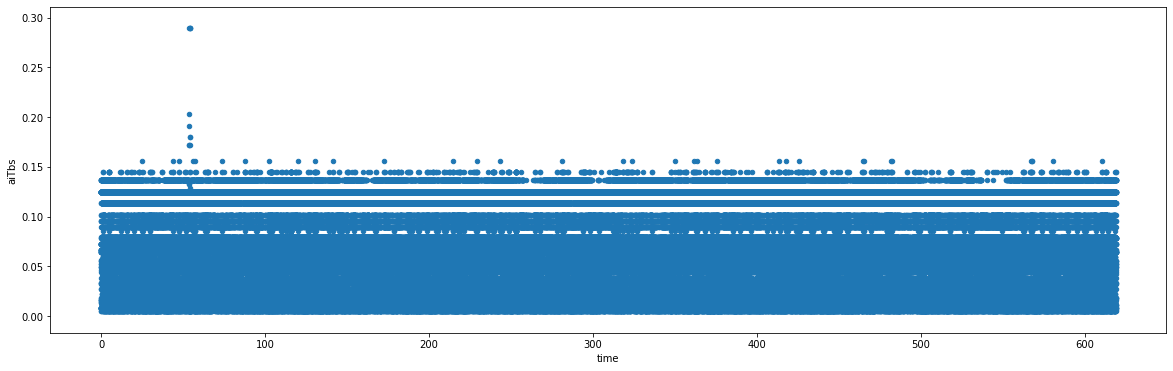

In [28]:
df_normal.plot.scatter(x='time', y='aiTbs', figsize=(20,6))

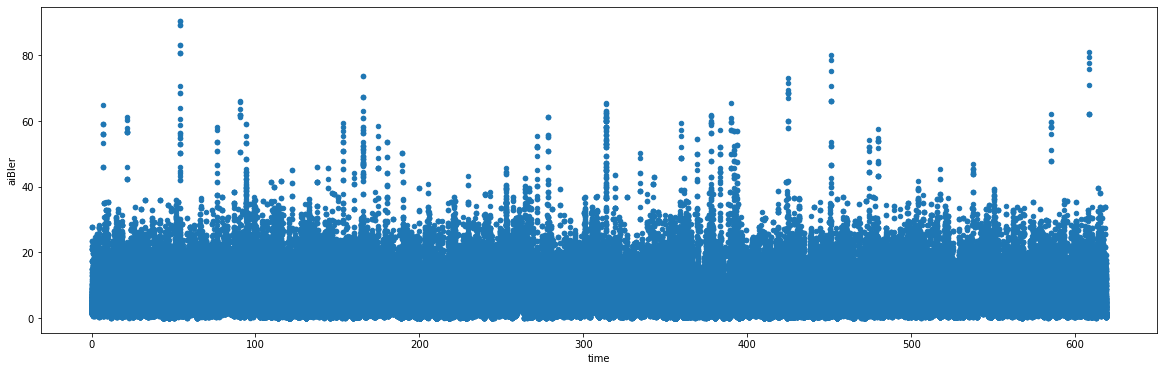

In [29]:
df_normal.plot.scatter(x='time',y='aiBler', figsize=(20,6))

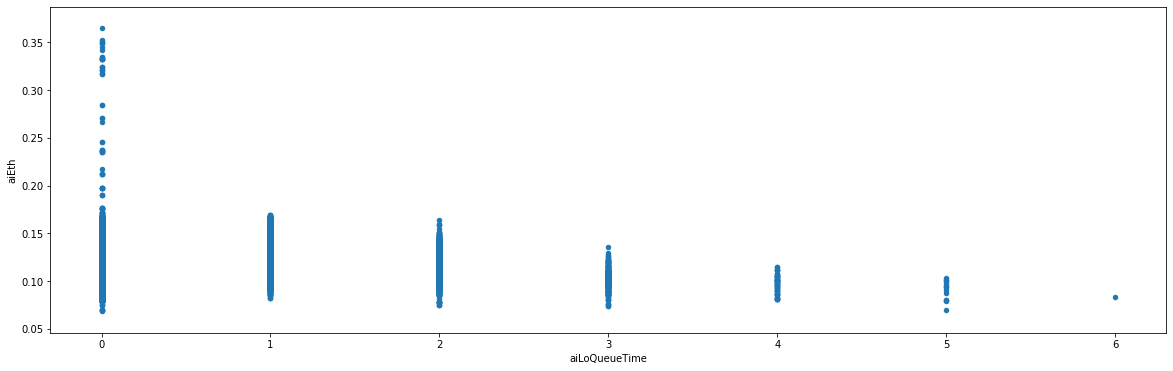

In [30]:
df_normal.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

In [13]:
dfg_normal = data_groupby(df_normal, time_period)

Groupy based on aiSfn with groupsize = 8...
Number of samples: (7736, 19) 
Number of missing samples: 0.0


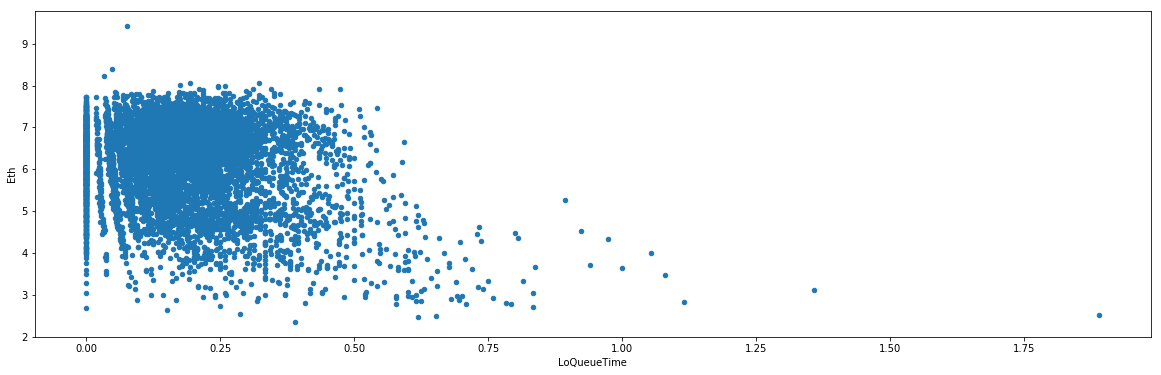

In [14]:
dfg_normal.plot.scatter(x='LoQueueTime',y='Eth', figsize=(20,6))

In [15]:
dfg_normal['label']= 1
dfg_normal.head()

,time,Sfn,Slot,nSlot,UeId,Mcs_mean,Mcs_min,Mcs_max,Cqi,Bler,Ack,Nack,LoQueueTime,Eth,RlcBuff,Modulation,RMCqi,Tbs,Tbs_per_slot,label
0,0.000000,0.00,3.71,43,0.0,12.279070,0.0,21.0,12.0,4.681628,40.0,2.0,0.093023,5.666000,1.832741,4.046512,9.460000,2.815643,6.548008,1
1,0.070243,0.01,3.18,36,0.0,14.638889,0.0,21.0,12.0,11.803889,31.0,5.0,0.222222,5.006104,1.687035,4.777778,9.327222,2.872581,7.979393,1
2,0.150521,0.02,4.05,51,0.0,12.549020,0.0,21.0,12.0,7.911373,48.0,2.0,0.196078,6.512207,2.277290,4.156863,9.294314,3.344742,6.558317,1
3,0.230799,0.03,4.51,54,0.0,13.925926,0.0,21.0,12.0,4.649444,53.0,2.0,0.148148,6.685394,1.875145,4.518519,9.418148,4.006416,7.419289,1
4,0.311066,0.04,4.13,45,0.0,12.466667,0.0,21.0,12.0,3.631333,45.0,1.0,0.000000,6.368561,0.856483,3.955556,9.546889,3.016907,6.704237,1


In [10]:
df_normal['label']=1
df_normal.head()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
0,0.0,1.0,0.0,16.0,1,0.0,0.0,0.0,21.0,273.0,0.136757,12.0,8.42,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,6.0,9.52,4.294967e+09,0.0,1.0,0.0,1
1,0.0,1.0,0.0,17.0,1,0.0,0.0,0.0,2.0,273.0,0.014168,12.0,8.21,0.0,15.36,1.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.52,4.294967e+09,0.0,1.0,0.0,1
2,0.0,1.0,0.0,18.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,8.21,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.52,4.294967e+09,0.0,1.0,0.0,1
3,0.0,1.0,1.0,3.0,1,0.0,0.0,0.0,5.0,273.0,0.016113,12.0,7.41,0.0,15.36,4.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,2.0,9.54,4.294967e+09,0.0,1.0,0.0,1
4,0.0,1.0,1.0,5.0,1,0.0,0.0,0.0,21.0,273.0,0.136757,12.0,7.41,0.0,15.36,0.0,0.0,0.0,0.0,0.125671,0.0,0.0,0.040115,6.0,9.54,4.294967e+09,0.0,1.0,0.0,1


# good data

In [11]:
filepath = './dataset/20190904_QoE/good_qoe_Result_20190904-154124.csv'
df_good = data_clean(filepath=filepath)
df_good = data_norm(df_good)
df_good.head()

Data cleaning...
The shape of data: (177952, 30)
Number of valid samples: (170717, 30)
index 24376 need to be reordered!!
index 38508 need to be reordered!!
index 43015 need to be reordered!!
index 55144 need to be reordered!!
index 55145 need to be reordered!!
index 59160 need to be reordered!!
index 59161 need to be reordered!!
index 77873 need to be reordered!!
index 86442 need to be reordered!!
index 104049 need to be reordered!!
index 104050 need to be reordered!!
index 117897 need to be reordered!!
index 117898 need to be reordered!!
index 126432 need to be reordered!!
index 135400 need to be reordered!!
index 135401 need to be reordered!!
index 140054 need to be reordered!!
index 153546 need to be reordered!!
index 162057 need to be reordered!!
Total time duration for this dataset: 408.0304551124573
Int64Index([83774, 123337, 161732, 163904], dtype='int64')
Data shape after duplicate removal: (170713, 29)
Time for remove duplicate: 0.311769962310791.
sfn_max = 40803.0, sfn min =

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
0,0.0,1.0,0.0,2.0,1,0.0,0.0,0.0,16.0,273.0,0.191505,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000
1,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,9.0,273.0,0.099655,15.0,0.0,0.0,21.15,1.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,2.0,13.28,0.0,0.0,1.0,0.000000
2,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,14.0,273.0,0.093819,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000
3,1.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,0.017601,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,2.0,13.28,0.0,0.0,1.0,0.005015
4,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,0.144585,15.0,0.0,0.0,21.15,2.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,4.0,13.28,0.0,0.0,1.0,0.005015


In [12]:
df_good.describe()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time
count,170713.000000,170713.0,170713.000000,170713.000000,170713.0,170713.0,170713.0,170713.0,170713.000000,170713.0,170713.000000,170713.000000,170713.000000,170713.0,170713.000000,170713.000000,170713.000000,170713.000000,170713.000000,170713.000000,170713.0,170713.0,170713.000000,170713.000000,170713.000000,1.707130e+05,170713.0,170713.0,170713.000000
mean,40645.836954,1.0,20392.327936,9.397937,1.0,0.0,0.0,0.0,9.767258,273.0,0.102431,14.965832,2.031147,0.0,21.084055,0.977131,0.023332,0.017948,0.000182,0.387962,0.0,0.0,0.041148,3.339195,13.798619,1.575657e+09,0.0,1.0,203.926275
std,23624.174346,0.0,11852.629181,5.155875,0.0,0.0,0.0,0.0,7.318218,0.0,0.069864,0.181662,4.674816,0.0,0.350608,1.003925,0.174128,0.743062,0.013474,0.041174,0.0,0.0,0.068269,1.467552,0.667248,2.069958e+09,0.0,0.0,118.526296
min,0.000000,1.0,0.000000,2.000000,1.0,0.0,0.0,0.0,0.000000,273.0,0.005135,14.000000,0.000000,0.0,19.220000,0.000000,0.000000,0.000000,0.000000,0.157845,0.0,0.0,0.000000,2.000000,11.120000,0.000000e+00,0.0,1.0,0.000000
25%,19827.000000,1.0,9947.000000,5.000000,1.0,0.0,0.0,0.0,3.000000,273.0,0.032249,15.000000,0.000000,0.0,21.150000,0.000000,0.000000,0.000000,0.000000,0.363846,0.0,0.0,0.000000,2.000000,13.260000,0.000000e+00,0.0,1.0,99.474877
50%,40906.000000,1.0,20523.000000,10.000000,1.0,0.0,0.0,0.0,11.000000,273.0,0.099655,15.000000,0.100000,0.0,21.150000,1.000000,0.000000,0.000000,0.000000,0.390083,0.0,0.0,0.000000,4.000000,13.850000,0.000000e+00,0.0,1.0,205.231583
75%,61220.000000,1.0,30715.000000,15.000000,1.0,0.0,0.0,0.0,16.000000,273.0,0.179840,15.000000,1.670000,0.0,21.150000,2.000000,0.000000,0.000000,0.000000,0.415482,0.0,0.0,0.063660,4.000000,14.440000,4.294967e+09,0.0,1.0,307.150007
max,81327.000000,1.0,40803.000000,18.000000,1.0,0.0,0.0,0.0,28.000000,273.0,0.414162,15.000000,100.000000,0.0,21.150000,6.000000,4.000000,35.000000,1.000000,0.524666,0.0,0.0,0.381958,6.000000,14.730000,4.294967e+09,0.0,1.0,408.030455


In [21]:
dul_index0 = df_good.duplicated(subset=['aiLoQueueTime', 'aiEth'])
df_good_LoEth = df_good[~dul_index0]
df_good_LoEth.shape

(21552, 30)

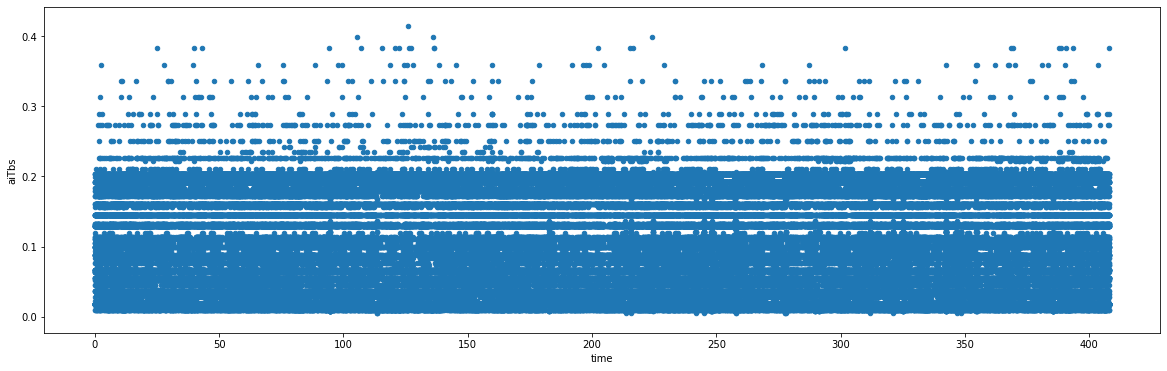

In [40]:
df_good.plot.scatter(x='time', y='aiTbs', figsize=(20,6))

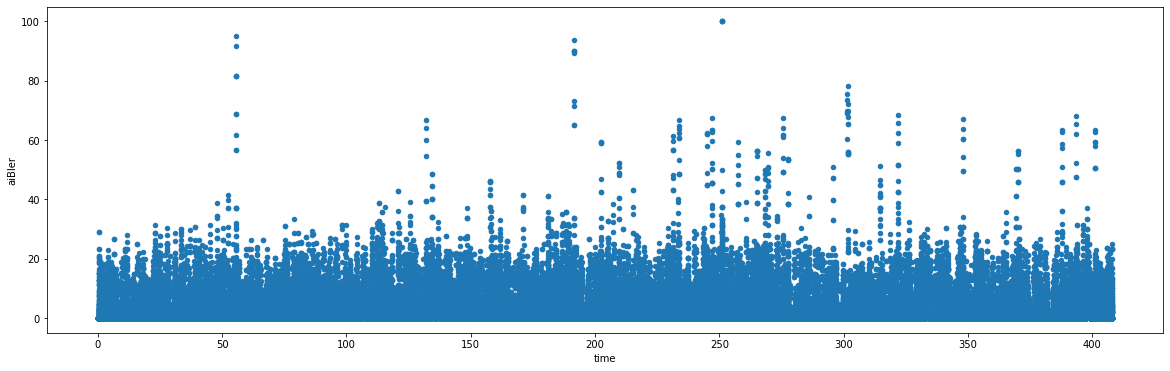

In [41]:
df_good.plot.scatter(x='time',y='aiBler', figsize=(20,6))

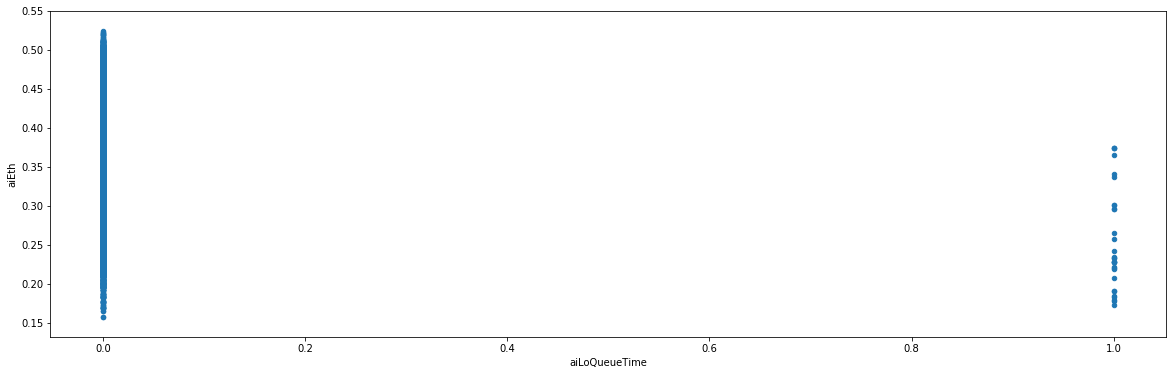

In [42]:
df_good.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

In [19]:
dfg_good = data_groupby(df_good, time_period)

Groupy based on aiSfn with groupsize = 8...
Number of samples: (5101, 19) 
Number of missing samples: 0.0


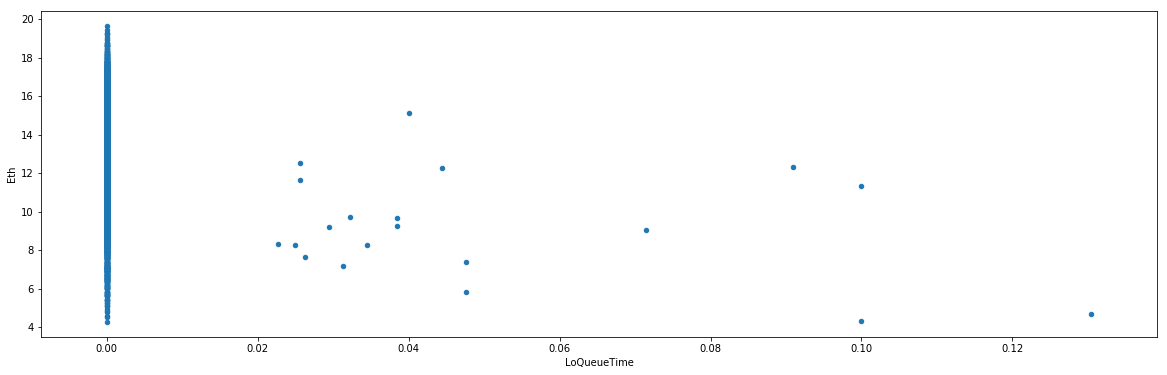

In [20]:
dfg_good.plot.scatter(x='LoQueueTime',y='Eth', figsize=(20,6))

In [21]:
dfg_good['label']= 0
dfg_good.head()

,time,Sfn,Slot,nSlot,UeId,Mcs_mean,Mcs_min,Mcs_max,Cqi,Bler,Ack,Nack,LoQueueTime,Eth,RlcBuff,Modulation,RMCqi,Tbs,Tbs_per_slot,label
0,0.000000,0.00,3.29,39,0.0,8.794872,0.0,22.0,15.0,0.0,37.0,0.0,0.0,14.762756,0.820145,3.128205,13.28,3.436188,8.810738,0
1,0.080277,0.01,3.88,40,0.0,9.350000,0.0,23.0,15.0,0.0,40.0,0.0,0.0,14.785019,0.582214,3.150000,13.28,3.785606,9.464016,0
2,0.160572,0.02,4.09,42,0.0,9.309524,0.0,23.0,15.0,0.0,42.0,0.0,0.0,15.193741,2.659706,3.238095,13.28,3.926376,9.348515,0
3,0.240858,0.03,3.95,42,0.0,8.119048,0.0,24.0,15.0,0.0,43.0,0.0,0.0,13.223824,3.378632,3.047619,13.28,3.439423,8.189101,0
4,0.321123,0.04,4.22,44,0.0,8.022727,0.0,20.0,15.0,0.0,43.0,0.0,0.0,15.772026,2.639725,2.909091,13.28,3.658218,8.314133,0


In [13]:
df_good['label']=0
df_good.head()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
0,0.0,1.0,0.0,2.0,1,0.0,0.0,0.0,16.0,273.0,0.191505,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000,0
1,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,9.0,273.0,0.099655,15.0,0.0,0.0,21.15,1.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,2.0,13.28,0.0,0.0,1.0,0.000000,0
2,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,14.0,273.0,0.093819,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000,0
3,1.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,0.017601,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,2.0,13.28,0.0,0.0,1.0,0.005015,0
4,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,0.144585,15.0,0.0,0.0,21.15,2.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,4.0,13.28,0.0,0.0,1.0,0.005015,0


# total data

In [14]:
df_total = pd.concat([df_good, df_normal, df])
df_total.head()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
0,0.0,1.0,0.0,2.0,1,0.0,0.0,0.0,16.0,273.0,0.191505,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000,0
1,0.0,1.0,0.0,7.0,1,0.0,0.0,0.0,9.0,273.0,0.099655,15.0,0.0,0.0,21.15,1.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,2.0,13.28,0.0,0.0,1.0,0.000000,0
2,0.0,1.0,0.0,8.0,1,0.0,0.0,0.0,14.0,273.0,0.093819,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.395195,0.0,0.0,0.007957,4.0,13.28,0.0,0.0,1.0,0.000000,0
3,1.0,1.0,0.0,10.0,1,0.0,0.0,0.0,0.0,273.0,0.017601,15.0,0.0,0.0,21.15,0.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,2.0,13.28,0.0,0.0,1.0,0.005015,0
4,1.0,1.0,0.0,15.0,1,0.0,0.0,0.0,13.0,273.0,0.144585,15.0,0.0,0.0,21.15,2.0,0.0,0.0,0.0,0.387878,0.0,0.0,0.000000,4.0,13.28,0.0,0.0,1.0,0.005015,0


In [15]:
df_total.describe()

,aiSendCount,aiIsValid,aiSfn,aiSlot,aiSlot_flag,aiS1TeID,aiUeId,aiBearId,aiMcs,aiNumOfPrb,aiTbs,aiCqi,aiBler,aiRssi,aiSinr,aiAck,aiNAck,aiTa,aiLoQueueTime,aiEth,aiPdcpBuffH,aiPdcpBuffL,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,aiCqiDel,aiTm,time,label
count,881491.000000,881491.0,881491.000000,881491.000000,881491.0,881491.0,881491.0,881491.0,881491.000000,881491.0,881491.000000,881491.000000,881491.000000,881491.0,881491.000000,881491.000000,881491.000000,881491.000000,881491.000000,881491.000000,881491.0,881491.0,881491.000000,881491.000000,881491.000000,8.814910e+05,881491.0,881491.0,881491.000000,881491.000000
mean,57319.267793,1.0,28757.721176,9.360260,1.0,0.0,0.0,0.0,12.952482,273.0,0.078330,12.381438,9.378058,0.0,16.098109,0.914257,0.086106,0.009053,0.174021,0.177706,0.0,0.0,0.052738,4.256332,10.017940,3.768335e+09,0.0,1.0,287.575529,1.213807
std,34487.996406,0.0,17302.959622,5.139541,0.0,0.0,0.0,0.0,7.499045,0.0,0.049167,1.326089,8.479671,0.0,2.557338,1.111737,0.327353,0.525180,0.418605,0.105378,0.0,0.0,0.072248,1.727680,1.895182,1.408733e+09,0.0,0.0,173.029033,0.745266
min,0.000000,1.0,0.000000,2.000000,1.0,0.0,0.0,0.0,0.000000,273.0,0.005135,11.000000,0.000000,0.0,13.440000,0.000000,0.000000,0.000000,0.000000,0.057709,0.0,0.0,0.000000,2.000000,8.000000,0.000000e+00,0.0,1.0,0.000000,0.000000
25%,27959.000000,1.0,14027.000000,5.000000,1.0,0.0,0.0,0.0,6.000000,273.0,0.037132,12.000000,2.580000,0.0,15.360000,0.000000,0.000000,0.000000,0.000000,0.120476,0.0,0.0,0.000000,2.000000,9.020000,4.294967e+09,0.0,1.0,140.271530,1.000000
50%,55809.000000,1.0,28000.000000,10.000000,1.0,0.0,0.0,0.0,15.000000,273.0,0.072281,12.000000,7.280000,0.0,15.360000,1.000000,0.000000,0.000000,0.000000,0.131744,0.0,0.0,0.002220,4.000000,9.160000,4.294967e+09,0.0,1.0,280.000832,1.000000
75%,84654.000000,1.0,42472.000000,15.000000,1.0,0.0,0.0,0.0,20.000000,273.0,0.113388,12.000000,14.370000,0.0,15.360000,2.000000,0.000000,0.000000,0.000000,0.147621,0.0,0.0,0.102837,6.000000,9.510000,4.294967e+09,0.0,1.0,424.712687,2.000000
max,123353.000000,1.0,61887.000000,18.000000,1.0,0.0,0.0,0.0,28.000000,273.0,0.414162,15.000000,100.000000,0.0,21.150000,6.000000,5.000000,35.000000,7.000000,0.524666,0.0,0.0,0.638741,6.000000,14.730000,4.294967e+09,0.0,1.0,618.866810,2.000000


In [16]:
dul_index = df_total.duplicated(subset=['aiLoQueueTime', 'aiEth'])
df_total_LoEth = df_total[~dul_index]
df_total_LoEth.shape

(43912, 30)

In [12]:
df_total.shape

(881492, 30)

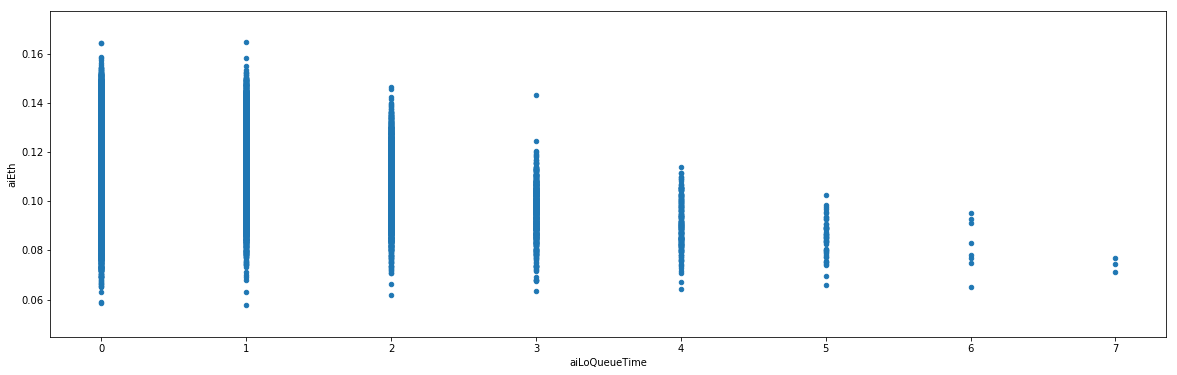

In [22]:
df_LoEth.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

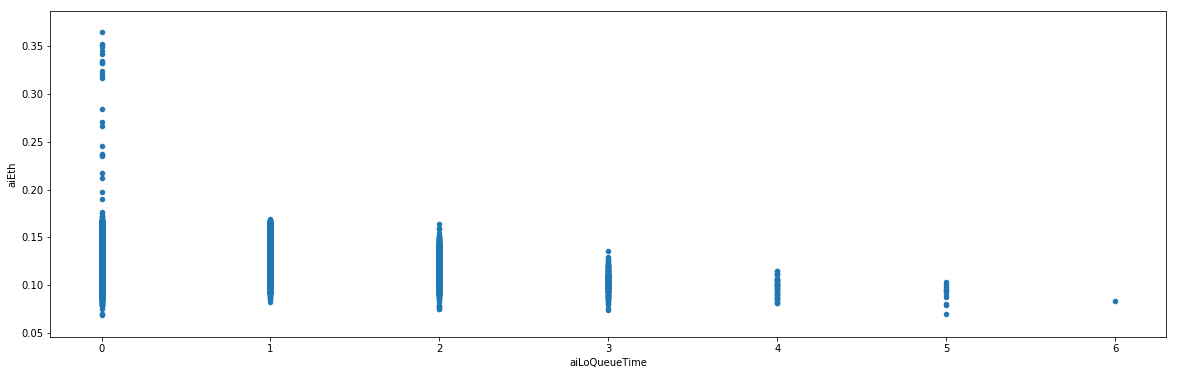

In [23]:
df_normal_LoEth.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

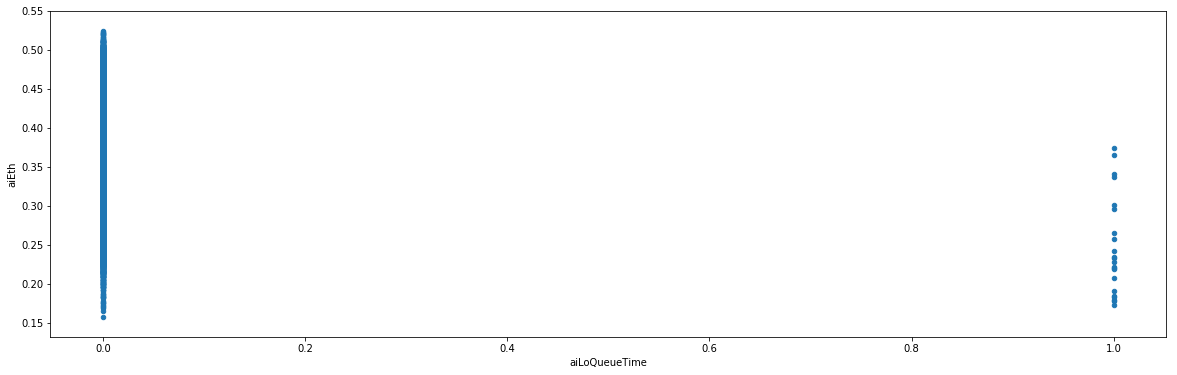

In [24]:
df_good_LoEth.plot.scatter(x='aiLoQueueTime',y='aiEth', figsize=(20,6))

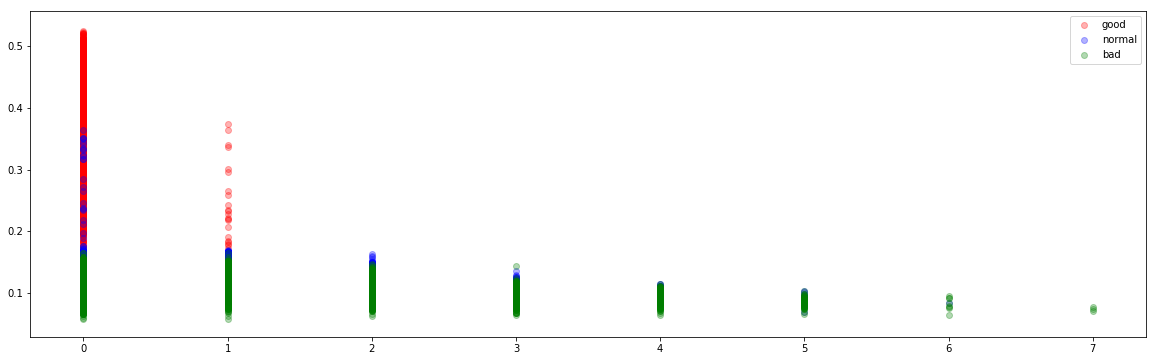

In [29]:
fig = plt.figure(facecolor='white',figsize=(20,6))
ax = fig.add_subplot(111)
plt.scatter(df_good_LoEth['aiLoQueueTime'], df_good_LoEth['aiEth'], c= 'r', alpha=0.3, label='good')
plt.scatter(df_normal_LoEth['aiLoQueueTime'], df_normal_LoEth['aiEth'], c= 'b', alpha=0.3,label='normal')
plt.scatter(df_LoEth['aiLoQueueTime'], df_LoEth['aiEth'], c= 'g', alpha=0.3,label='bad')
plt.legend()

In [11]:
std_zero_lst= []
valid_lst = []
for _col in df_total.columns:
    if df_total[_col].std() == 0:
        std_zero_lst.append(_col)
    else:
        valid_lst.append(_col)
print(f"zero std features: {std_zero_lst}")
print(f"valid features: {valid_lst}")

zero std features: ['aiIsValid', 'aiSlot_flag', 'aiS1TeID', 'aiUeId', 'aiBearId', 'aiNumOfPrb', 'aiRssi', 'aiPdcpBuffH', 'aiPdcpBuffL', 'aiCqiDel', 'aiTm']
valid features: ['aiSendCount', 'aiSfn', 'aiSlot', 'aiMcs', 'aiTbs', 'aiCqi', 'aiBler', 'aiSinr', 'aiAck', 'aiNAck', 'aiTa', 'aiLoQueueTime', 'aiEth', 'aiRlcBuff', 'aiMod', 'aiRMCqi', 'aiCqiCmp', 'time', 'label']


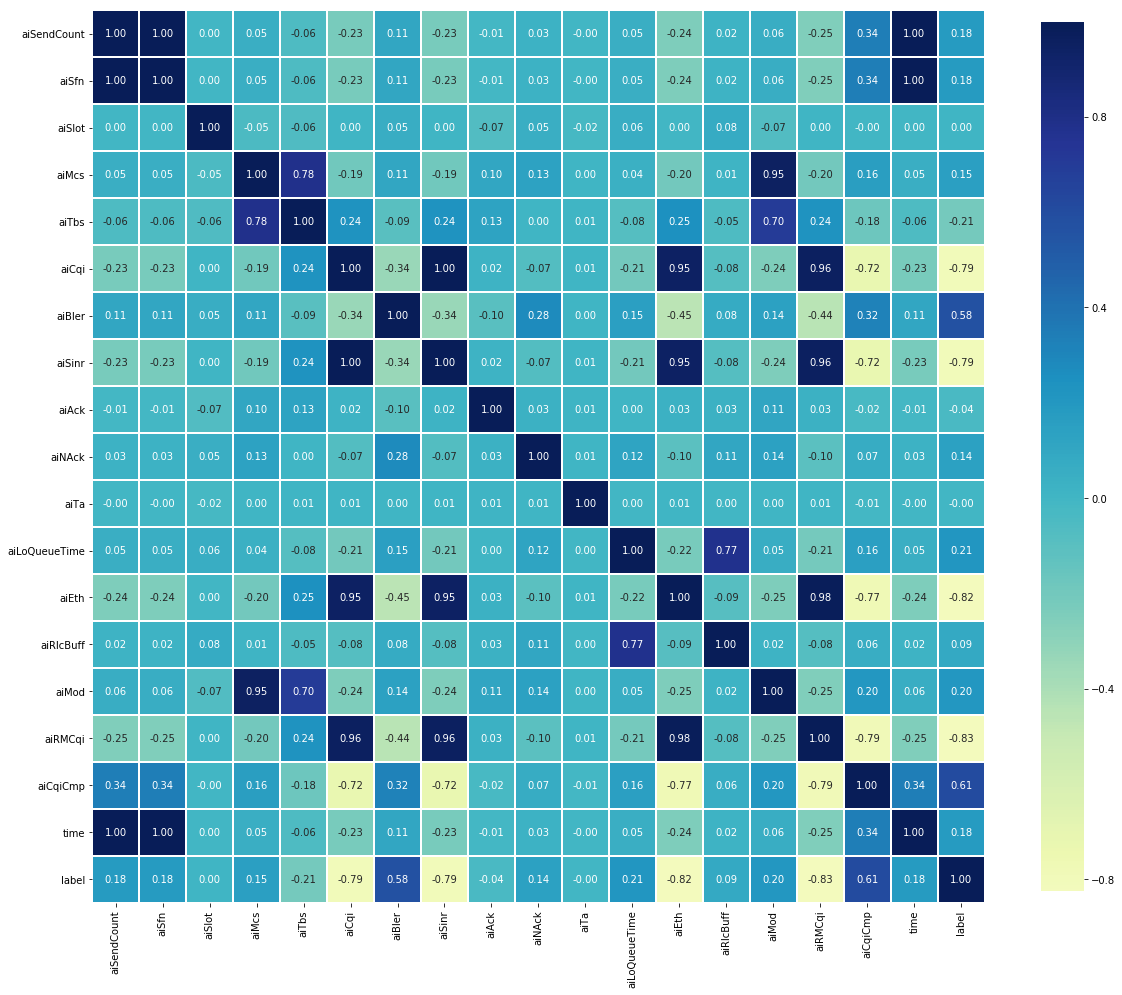

In [34]:
correlation_heatmap(df_total[valid_lst].corr())

# Model training

In [12]:
drop_cols = ['aiSendCount', 'aiSfn', 'aiSlot','aiSinr','aiTa','time']
df_train_data = df_total.drop(std_zero_lst, axis=1)
df_train_data = df_train_data.drop(drop_cols, axis=1)
df_train_data.head()

,aiMcs,aiTbs,aiCqi,aiBler,aiAck,aiNAck,aiLoQueueTime,aiEth,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,label
0,16.0,0.191505,15.0,0.0,0.0,0.0,0.0,0.395195,0.007957,4.0,13.28,0.0,0
1,9.0,0.099655,15.0,0.0,1.0,0.0,0.0,0.395195,0.007957,2.0,13.28,0.0,0
2,14.0,0.093819,15.0,0.0,0.0,0.0,0.0,0.395195,0.007957,4.0,13.28,0.0,0
3,0.0,0.017601,15.0,0.0,0.0,0.0,0.0,0.387878,0.000000,2.0,13.28,0.0,0
4,13.0,0.144585,15.0,0.0,2.0,0.0,0.0,0.387878,0.000000,4.0,13.28,0.0,0


In [13]:
df_train_data['aiCqiCmp'] = df_train_data['aiCqiCmp']/df_train_data['aiCqiCmp'].max()
df_train_data['aiBler'] = df_train_data['aiBler']/df_train_data['aiBler'].max()

In [41]:
df_train_data.describe()

,aiMcs,aiTbs,aiCqi,aiBler,aiAck,aiNAck,aiLoQueueTime,aiEth,aiRlcBuff,aiMod,aiRMCqi,aiCqiCmp,label
count,881492.00000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000,881492.000000
mean,12.95249,0.078330,12.381437,0.093781,0.914256,0.086106,0.174021,0.177706,0.052738,4.256334,10.017939,0.877384,1.213807
std,7.49905,0.049167,1.326088,0.084797,1.111738,0.327353,0.418605,0.105377,0.072248,1.727683,1.895181,0.327996,0.745266
min,0.00000,0.005135,11.000000,0.000000,0.000000,0.000000,0.000000,0.057709,0.000000,2.000000,8.000000,0.000000,0.000000
25%,6.00000,0.037132,12.000000,0.025800,0.000000,0.000000,0.000000,0.120476,0.000000,2.000000,9.020000,1.000000,1.000000
50%,15.00000,0.072281,12.000000,0.072800,1.000000,0.000000,0.000000,0.131744,0.002220,4.000000,9.160000,1.000000,1.000000
75%,20.00000,0.113388,12.000000,0.143700,2.000000,0.000000,0.000000,0.147621,0.102837,6.000000,9.510000,1.000000,2.000000
max,28.00000,0.414162,15.000000,1.000000,6.000000,5.000000,7.000000,0.524666,0.638741,6.000000,14.730000,1.000000,2.000000


In [14]:
train_data = df_train_data.values
shuffle_list = list(range(train_data.shape[0]))
np.random.shuffle(shuffle_list)
train_data = train_data[shuffle_list, :]
split_rate = 0.8
train_size = int(train_data.shape[0] * split_rate)
train = train_data[:train_size, :]
test = train_data[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(f"{train_X.shape}, {train_y.shape}, {test_X.shape}, {test_y.shape}")

(705193, 12), (705193,), (176299, 12), (176299,)


In [15]:
import keras
num_classes = 3
y_train = keras.utils.to_categorical(train_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

In [16]:
y_train.shape

(705193, 3)

In [17]:
def dnn_model(n_features):
    model = Sequential()
    # Dense model
    model.add(Dense(128, input_shape=(n_features,),activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


In [18]:
n_features = train_X.shape[1]
qoe_model = dnn_model(n_features)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 5,891
Trainable params: 5,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 10
save_path = os.path.join('gNB_QoE/', '%s.h5' % (dt.datetime.now().strftime('%Y%m%d-%H%M%S')))
callbacks = [ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)]
history = qoe_model.fit(train_X, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_X, y_test),
                        callbacks=callbacks)
score = qoe_model.evaluate(x_test, y_test)
print(f"model evaluation score: {score}")

Train on 705193 samples, validate on 176299 samples
Epoch 1/10
705193/705193 [==============================] - 38s 54us/step - loss: 0.2987 - acc: 0.8733 - val_loss: 0.2870 - val_acc: 0.8794
Epoch 2/10
705193/705193 [==============================] - 39s 55us/step - loss: 0.2925 - acc: 0.8752 - val_loss: 0.2894 - val_acc: 0.8781
Epoch 3/10
705193/705193 [==============================] - 40s 57us/step - loss: 0.2875 - acc: 0.8768 - val_loss: 0.2799 - val_acc: 0.8795
Epoch 4/10
181632/705193 [======>.......................] - ETA: 30s - loss: 0.2833 - acc: 0.8786